<div align='center'>
    
# Demonstration Notebook

##  Image Registration

### 29 March 2023
    Version 0.85
    
</div>

## 
This is a little demonstration that has been prepared to support the learning outcomes of Chapter 6: Image Registration. It replaces a demo I used to circulate, written in _Matlab_, but in 2D; this version is in 3D and is written to use _Python_. 

I have included this as a demonstration of

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from os import wait

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from scipy.ndimage import affine_transform as at
from scipy.ndimage import zoom as zoom
from scipy.ndimage import gaussian_filter as gaussian_filter
from scipy.ndimage import gaussian_gradient_magnitude as gradmag

## Part 1: Preliminaries
We are going to start by playing around with transforming an image in 2D. Though we will start with rotation in the $(x,y)$ plane, we will move to rotation and translation in 2D before extending things into 3D.

We will use the following image (since we all probably need a holiday at this point....

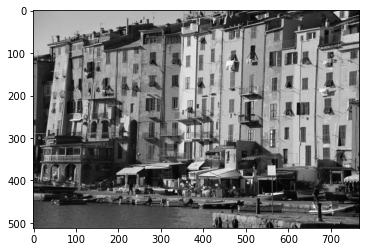

In [2]:
Xc = Image.open('./IMGS/Image15.jpg')
xg = rgb2gray(Xc)
plt.imshow(xg, cmap='gray')

### First step, applying a geometric transormation to an image
We will take this journey by first simply trying to apply a simple 2D rotation to this image, see what
goes wrong, and fix it! In doing this, we are exposing the process by which one goes about
solving problems, given a rough idea of what it is one wishes to do. 

Let's rotate this image by a small amount, so we can hope to understand how this works, and what issues arise...I found the scipy.ndimage is the best routine for this; other modules for doing this are endlessly wrapped in nonsense extra code that adds nothing but complexity. The scipi.ndimage has a routine called "affine_transform" that allows a matrix to be specified, and does the interpolation that is needed to resample the data.

In [44]:
theta = np.pi/16

# By reading the documentation, I see that the command 
myrotmat = [[np.cos(theta), np.sin(theta), 0.0],
            [-np.sin(theta), np.cos(theta), 0.0],
            [0.0, 0.0, 1.0]]

myrotmat = np.asarray(myrotmat, dtype=float)

# Order = 1 gives us us bilinear interpolation; I have not described
# all parameters, but you can consult the online documentation for scipy.ndimage
transformed_xg = at(xg, myrotmat, offset=0.0, output_shape=None,
   output=None, order=1, mode='constant', cval=0.0, prefilter=True)

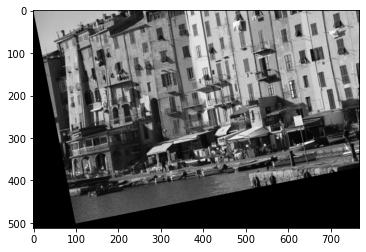

In [45]:
plt.imshow(transformed_xg, cmap='gray')

### Observe:

  a) the rotation is _clockwise_
  
  b) this is rotating the image about its top left-hand corner. 
  
In response to "b)", we might ask: How do we get the rotation to be about the centre of the image?

**Answer**: _matrix magic_ (not really, it's more like the magic of matrices...).
Since the affine transform that we are using seems to be rotating about (0,0), we could shift the centre of the image to that point, then rotate the image as before, then translate the image back to its original position. The cool thing is that we can do all of this by just building a single matrix that _composes_ all of these trasformations together.

In [46]:
# Get centre of image
ctr_y, ctr_x = (np.array(xg.shape)-1) / 2.

# Create a pure translation matrix; observe the structure
mypreshiftmat = [[1.0, 0.0, -ctr_x],
                 [0.0, 1.0, -ctr_y],
                 [0.0, 0.0, 1.0]]

# Create a pure translation matrix; observe the structure
mypostshiftmat = [[1.0, 0.0, ctr_x],
                  [0.0, 1.0, ctr_y],
                  [0.0, 0.0, 1.0]]

# Now, compose the total transformation by applying the
# rotation matrix to the pre-shift (multiply with
# rotation mat from the left)...
comp_mat1 = np.matmul(myrotmat,mypreshiftmat)

#... and shift back to the origin...
comp_mat2 = np.matmul(mypostshiftmat,comp_mat1)

In [47]:
comp_mat2

array([[  0.98078528,   0.19509032, -42.47673231],
       [ -0.19509032,   0.98078528,  79.72649935],
       [  0.        ,   0.        ,   1.        ]])

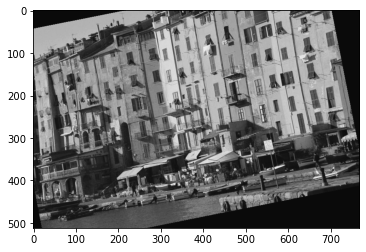

In [48]:
# Create our transformation...
transformed_xg = at(xg, comp_mat2, offset=0.0, output_shape=None,
   output=None, order=3, mode='constant', cval=0.0, prefilter=True)

# ... and show it
plt.imshow(transformed_xg, cmap='gray')

## Part 2: 3D Data and Transformations
In what follows below, we show how to perform 3D transformations on volumetric data,
explore data reslicing and also some cool tricks to visualise data.

In [49]:
f = h5py.File('p170.h5', 'r')

In [50]:
list(f.keys())

['MassDen', 'Rho', 'T1', 'T2', 'T2Star']

In [51]:
# Extract one of the fields out of the hd5 object
T1vol = f['T1']

In [52]:
# Look at tge shape of this:
T1vol.shape # You will see that this is 3D

(64, 64, 64)

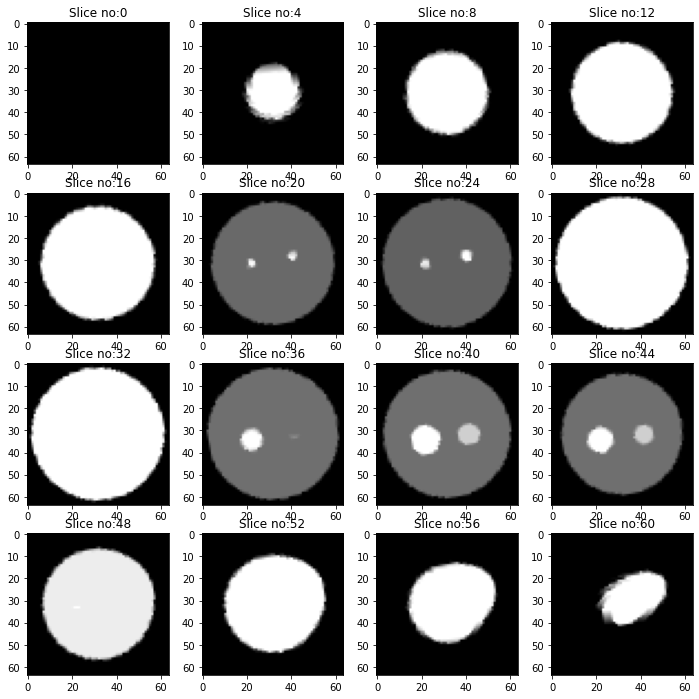

In [53]:
# Now, let us look at a few slices through this
NRows=4
NCols=4
fig, axs = plt.subplots(NRows,NCols, figsize=(12,12))
sliceno = 0
for m in range(NRows):
    for n in range(NCols):
        axs[m][n].imshow(T1vol[sliceno,:,:],cmap='gray')
        axs[m][n].set_title('Slice no:' + str(sliceno))
        sliceno += 4 # Show every fourth slice

### Observe
This volume is almost spherical, but has a bit of a protrusion (look at slices 52-60), which makes it a bit irregular in shape. Instead of displaying this data slice by slice, we can display it as a
pseudo-3D plot. There are two ways to do this: i) find surfaces and render those; ii) assign transparancy values and use ray-tracing. 

We can approximate the latter with a simple trick, whereby we sum or find the mean value along one axis, sometimes described as _projecting_ the data along one axis, collapsing the 3D array into a 2D array. Then, we can repeatedly rotate the volume in space, and re-project, creating an animation of the
rotating volume. This approach mimics the idea of Beer's law, which describes the physics of collecting X-ray projections through a solid object.

Animating the rotation directly is difficult to do effectively in a Jupyter Notebook without lots of installation (we need interactive tools to be installed), but we can create and save a movie file, then use an external viewer to play the animation. This is what we will do. First, define the angles we will use for the projections

In [54]:
rotation_angles = np.linspace(0,360,50) # Create angles in [0,360] degrees in 50 steps

Next, we create a utility routine to construct a transformation matrix given a single rotation angle, theta. The way we use this angle to create the matrix will determine whether it is a rotation along $x$, $y$ or $z$ axes; see the notes if you can't remember how this works!

In [55]:
def construct3Drotationmat(theta):
    # Given the construction of the rotation matrix below, this
    # will describe a rotation about the z axis (in the x-y plane)
    rotmat = [[np.cos(theta), np.sin(theta), 0.0, 0.0],
            [-np.sin(theta), np.cos(theta), 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]]

# Get centre of image
    ctr_y, ctr_x, ctr_z = (np.array(T1vol.shape)-1) / 2.

# Create a pure translation matrix; observe the structure
    mypreshiftmat = [[1.0, 0.0, 0.0, -ctr_x],
                 [0.0, 1.0, 0.0, -ctr_y],
                 [0.0, 0.0, 1.0, -ctr_z],
                 [0.0, 0.0, 0.0, 1.0]]

# Create a pure translation matrix; observe the structure
    mypostshiftmat = [[1.0, 0.0, 0.0, ctr_x],
                 [0.0, 1.0, 0.0, ctr_y],
                 [0.0, 0.0, 1.0, ctr_z],
                 [0.0, 0.0, 0.0, 1.0]]

# Now, compose the total transformation by applying the
# rotation matrix to the pre-shift (multiply with
# rotation mat from the left)...
    comp_mat1 = np.matmul(rotmat,mypreshiftmat)

#... and shift back to the origin...
    comp_mat2 = np.matmul(mypostshiftmat,comp_mat1)
    
    return comp_mat2

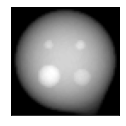

In [56]:
# Let's now loop over the angles and create the rotation matrix about z...
# Create an empty list to hold each rendered image...
fig, ax = plt.subplots(figsize=(2,2))
Projected_Image_List = []
for i in range(len(rotation_angles)):
    angleinrads = rotation_angles[i]*np.pi/180.0
    matrix = construct3Drotationmat(angleinrads)
    transformed_vol = at(T1vol, matrix, offset=0.0, output_shape=None,
                         output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    projected_vol = np.sum(transformed_vol,axis=1)
    frame = ax.imshow(projected_vol, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    Projected_Image_List.append([frame]) # store the image frame in a list
    

### Creating an Animation file

The following bit of code creates an animation using the so-called "Artist" method, which can
work off of a list of frames previously generated using a matplotlib command. The video is encoded to be at 30fps; the interval between frames may or may not have an effect (in priciple, it should, but not sure how inconsistencies are resolved with the "fps" argument (no time to check documentation this year!)

In [57]:
import matplotlib.animation as animation

anim = animation.ArtistAnimation(
                               fig, 
                               Projected_Image_List, 
                               interval=33, # millisiconds
                               blit= True, repeat_delay=0
                               )

anim.save('rot_anim.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

## Part 3: Registration Using Optimisation

For the registration, it is usful to make the problem a bit more difficult, and permit bigger
translatiions, as the image is very "tight" inside the volume. So, what I have done is to embed a lower resolution version of the volume into a 64x646x64 empty volume. This has the added effect of
making the registration a bit more complex, since some detail is lost. I kept the volume of 64x64x64
as embedding the original resolution volume into a bigger volume that $64^3$ would have made the registration demo too slow, and memory intensive.

At the end of this, our reference volume will be assigned to variable `A`.

In [58]:
T1vol_small = zoom(T1vol, 0.5)
A=np.zeros((64,64,64))
A[16:48,16:48,16:48]=T1vol_small

We are going to try to get the registration to search across 6 parameters of
geometric transformation space; this means we have to be able to rotate around
all three axes, and translate as well. 

It is sensible to create some nice clean transformation matrices for each rotation, and the translation. Please consult the main lecture notes to understand these constructions a bit better.

In [59]:
def TrotX(theta):
    # theta must be in radians
    rotmat = [[1.0, 0.0, 0.0, 0.0],
            [0.0, np.cos(theta), -np.sin(theta), 0.0],
            [0.0, np.sin(theta), np.cos(theta), 0.0],
            [0.0, 0.0, 0.0, 1.0]]
    
    return np.asarray(rotmat, dtype=float)

def TrotY(theta):
    rotmat = [[np.cos(theta), 0.0, np.sin(theta), 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [-np.sin(theta), 0.0, np.cos(theta), 0.0],
            [0.0, 0.0, 0.0, 1.0]]
    
    return np.asarray(rotmat, dtype=float)

def TrotZ(theta):
    
    rotmat = [[np.cos(theta), np.sin(theta), 0.0, 0.0],
            [-np.sin(theta), np.cos(theta), 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]]
    
    return np.asarray(rotmat, dtype=float)

def TransXYZ(tx,ty,tz):
    
    transmat = [[1.0, 0.0, 0.0, tx],
        [0.0, 1.0, 0.0, ty],
        [0.0, 0.0, 1.0, tz],
        [0.0, 0.0, 0.0, 1.0]]
    
    return np.asarray(transmat, dtype=float)

### Applying a forward geometric transform to volume A

In [60]:
# Set the random seed for reproducibility of demo
np.random.seed(seed=1)

# Now, let us create "B" our translated and rotated volume
randomtranslationvec = 40.0*(np.random.rand((3))-0.5)

# Could use random rotations, but I have simplified this and am
# Just applying rotation around 1 axis...
randomrotangle = 180.0*(np.random.rand()-0.5)


As for the 2D case, it is convenient to be able to translate the volume so that its
centre aligns at the centre of rotation. This will be element [0,0,0] (we know this from 
experimenting with the 2D version of rotation; so, we repeat what we did for the image case on
the volume case:

In [61]:
# Get centre in order to transform th coordinate system to
# align with centre of rotation
ctr_y, ctr_x, ctr_z = (np.array(T1vol.shape)-1) / 2.

In [62]:
def constructtransformmatrix(x, ctr_x, ctr_y, ctr_z):
    # Parameters of 6D vector x are tx,ty,tz,thetax,thetay,thetaz
    # Create a pure translation matrix; observe the structure
    
    Rx = TrotX(x[3])
    Ry = TrotY(x[4])
    Rz = TrotZ(x[5])
    
    Tt = TransXYZ(x[0],x[1],x[2])
    
    T = np.matmul(Tt,np.matmul(Rz,(np.matmul(Ry,Rx))))
    
    mypreshiftmat = [[1.0, 0.0, 0.0, -ctr_x],
                     [0.0, 1.0, 0.0, -ctr_y],
                     [0.0, 0.0, 1.0, -ctr_z],
                     [0.0, 0.0, 0.0, 1.0]]

    # Create a pure translation matrix; observe the structure
    mypostshiftmat = [[1.0, 0.0, 0.0, ctr_x],
                      [0.0, 1.0, 0.0, ctr_y],
                      [0.0, 0.0, 1.0, ctr_z],
                      [0.0, 0.0, 0.0, 1.0]]
    
    Ta = np.matmul(T,np.asarray(mypreshiftmat,dtype=float))
    Tb = np.matmul(np.asarray(mypostshiftmat,dtype=float), Ta)
    
    return Tb

Now, we compose the random rotation and translation angles together and make
a forward transformation matrix. Our aim n registration will be to try to estimate
a transformation that invertes this using voxel-based registration.

In [63]:
thetavec = np.asarray([randomrotangle*np.pi/180.0,0.0,0.0],dtype=float)
forwardx = np.concatenate((randomtranslationvec,thetavec))
ForwardT = constructtransformmatrix(forwardx,ctr_x,ctr_y,ctr_z)

Apply transformation matrix, to yield `B`. Our aim will then be to try to transform `B` back to be aligned with `A`.

In [64]:
B = at(A, ForwardT, offset=0.0, output_shape=None,
                         output=None, order=3, mode='constant', cval=0.0, prefilter=True)

Text(0.5, 1.0, 'B, Transformed')

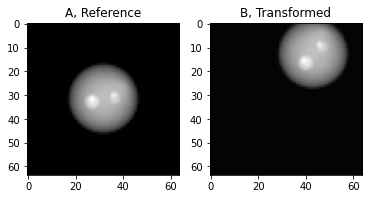

In [65]:
fig,axs = plt.subplots(1,2,figsize=(6,6))
axs[0].imshow(np.sum(A,axis=0),cmap='gray')
axs[0].set_title('A, Reference')
axs[1].imshow(np.sum(B,axis=0),cmap='gray')
axs[1].set_title('B, Transformed')

Note that there is a bit of truncation of `B` relative to that of `A`. This makes
the registration slightly more difficult to perform, as a small portion of the phantom is missing in one scan with respect to the other. This will often happen when the scan is of high-resolution.

### Using an Optimizer

In [73]:
# Let's get the optimization module, and grab "minimize"
from scipy.optimize import minimize

The Mean Square Error will be our voxel-based similarity measure:

In [74]:
def mse(x,A,B):
    # Mean Square Error
    # Parameters of x are tx,ty,tz,thetax,thetay,thetaz
    ctr_y, ctr_x, ctr_z = (np.array(A.shape)-1) / 2.
    
    TInvdash = constructtransformmatrix(x, ctr_x, ctr_y, ctr_z)
    
    Adash = at(B, TInvdash, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    
    
    dv = np.power((A-Adash),2)
    d = np.mean(dv)
    
    return d

In [75]:
# This is a utility function in case you want to look at the history
# of the optimisation over the parameter-space
VectorHistory = []
def capture(x):
    VectorHistory.append(x)
    print('.',end='')
    return    

In [76]:
# If we use the 'Powell' method, as below, we will sometimes get a "fail", depending on the
# random transformation that has been applied, and how big the shift is. Try it!
# You can also look at the `minimize()` documentation to see what other methods exist
# The various methods have different computational costs, and different degrees of
# precision, susceptibility to local minima and requirements. `Nelder-Mead` is popular,
# but turns out to fail on this problem.
x0 = np.asarray([0,0,0,0,0,0],dtype=float)
VectorHistory = [] # Just in case... set this to capture the history
xsol = minimize(mse, x0, args=(A,B), callback=capture, method='Powell')
print('.')
print('Done registering')

........
Done registering


In [77]:
xsol.x

array([ 3.29269572e+00, -1.87107031e+01,  1.11345086e+01,  6.20661131e-01,
        3.11474894e-04,  5.49729245e-10])

Text(0.5, 1.0, 'Adash, Registered')

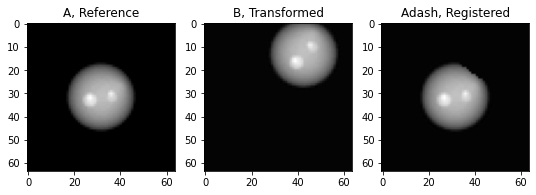

In [78]:
# Check the results by applying the estimated transform...
TInvdash = constructtransformmatrix(xsol.x, ctr_x, ctr_y, ctr_z)
Adash = at(B, TInvdash, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)

fig,axs = plt.subplots(1,3,figsize=(9,9))
axs[0].imshow(np.sum(A,axis=0),cmap='gray')
axs[0].set_title('A, Reference')
axs[1].imshow(np.sum(B,axis=0),cmap='gray')
axs[1].set_title('B, Transformed')
axs[2].imshow(np.sum(Adash,axis=0),cmap='gray')
axs[2].set_title('Adash, Registered')

### Two-stage (scale) optimisation
First, optimise on the blurred images, then take the estimated transform from the
blurred images and use as initial point for optimising the original resolution images.

........Blurred opt done...
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................Final opt done.


Text(0.5, 1.0, 'Adash_2, Registered')

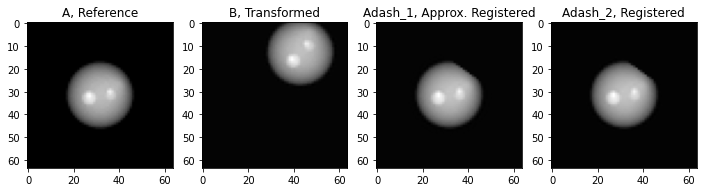

In [79]:
# I used "Powell" method below, because that seems to be more reliable
# at getting near to the true global optimum on the blurred images
xsol1 = minimize(mse, x0, args=(gaussian_filter(A,sigma=3),
                               gaussian_filter(B,sigma=3)), 
                               callback=capture, 
                               method='Powell')

# We should now have a parameter vector that gets is near to the
# global minimum; next, turn this infor a transormation matrix
TInvdash_1 = constructtransformmatrix(xsol1.x, ctr_x, ctr_y, ctr_z)

print('Blurred opt done...')

# Starting from the best solution on the blurred images (xsol1), go back
# to the original images and search for the true global optimum; this 
# is assigned to xsol 2.
xsol2 = minimize(mse, xsol1.x, args=(A,B), 
                               callback=capture, 
                               method='nelder-mead')

# We should now have a parameter vector that should be closer
# to the true transformation
TInvdash_2 = constructtransformmatrix(xsol2.x, ctr_x, ctr_y, ctr_z)

print('Final opt done.')

Adash_1 = at(B, TInvdash_1, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)


Adash_2 = at(B, TInvdash_2, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)

fig,axs = plt.subplots(1,4,figsize=(12,12))
axs[0].imshow(np.sum(A,axis=0),cmap='gray')
axs[0].set_title('A, Reference')
axs[1].imshow(np.sum(B,axis=0),cmap='gray')
axs[1].set_title('B, Transformed')
axs[2].imshow(np.sum(Adash_1,axis=0),cmap='gray')
axs[2].set_title('Adash_1, Approx. Registered')
axs[3].imshow(np.sum(Adash_2,axis=0),cmap='gray')
axs[3].set_title('Adash_2, Registered')

Text(0.5, 1.0, '0.0016371197372499354')

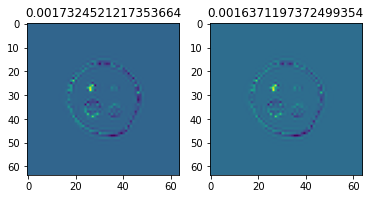

In [80]:
fig,axs = plt.subplots(1,2,figsize=(6,6))
d1 = A - Adash_1
mabs = np.mean(np.abs(d1))
axs[0].imshow(d1[:,32,:])
axs[0].set_title(str(mabs))
d2 = A - Adash_2
mabs = np.mean(np.abs(d2))
axs[1].imshow(d2[:,32,:])
axs[1].set_title(str(mabs))

Below, we show that using the gradient magnitude images derived from A and B with a bit of blurring to perform the second step of registration. This takes longer to execute each step, but converges with fewer steps: it is kep as a demonstration of the following: sometimes, registration in a simple feature space that preserves spatial edges can make the registration faster to converge.

In [ ]:
print('Blurred opt done...(so, using previous xsol1)')
gA = gradmag(A,sigma=1)
gB = gradmag(B,sigma=1)
xsol2 = minimize(mse, xsol1.x, args=(gA,gB), callback=capture, method='Powell')

TInvdash_2 = constructtransformmatrix(xsol2.x, ctr_x, ctr_y, ctr_z)

print('Final opt done.')

Adash_2 = at(B, TInvdash_2, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)

fig,axs = plt.subplots(1,3,figsize=(9,9))
axs[0].imshow(np.sum(A,axis=0),cmap='gray')
axs[0].set_title('A, Reference')
axs[1].imshow(np.sum(B,axis=0),cmap='gray')
axs[1].set_title('B, Transformed')
axs[2].imshow(np.sum(Adash_2,axis=0),cmap='gray')
axs[2].set_title('Adash_2, Registered')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(6,6))
d1 = A - Adash_1
mabs = np.mean(np.abs(d1))
axs[0].imshow(d1[:,32,:])
axs[0].set_title(str(mabs))
d2 = A - Adash_2
mabs = np.mean(np.abs(d2))
axs[1].imshow(d2[:,32,:])
axs[1].set_title(str(mabs))

Finally, there is something that is hidden in the use of the `affine_transform` (here, `at()`).
The function both applies a coordinate transform and also resamples the data on for transformation
matrices that map voxels onto inter-voxel locations (see lecture notes for 2D illustration). 

For this phantom volume, it does not make much difference which interpolater is used, visually, but it can do for other data. Below, a little demonstration of slicing the rotated phantom after using two different interpolation schemes: order 3 and order 0 (which is nearest neighbour).

In [ ]:
Adash_NN = at(B, TInvdash_2, offset=0.0, output_shape=None,
               output=None, order=0, mode='constant', cval=0.0, prefilter=True)

In [ ]:
Adash_QD = at(B, TInvdash_2, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(Adash_NN[16:48,16:48,32],cmap='gray')
axs[0].set_title('NN Interpolation')
axs[1].imshow(Adash_QD[16:48,16:48,32],cmap='gray')
axs[1].set_title('Cubic Interpolation')

### Below: not used...

In [ ]:
def mad(x,A,B):
    # No, not crazy, or angry, but Mean Absolute Difference
    # This is an alternative measure that you may wish to try
    # Parameters of x are tx,ty,tz,thetax,thetay,thetaz
    ctr_y, ctr_x, ctr_z = (np.array(A.shape)-1) / 2.
    
    TInvdash = constructtransformmatrix(x, ctr_x, ctr_y, ctr_z)
    
    Adash = at(B, TInvdash, offset=0.0, output_shape=None,
               output=None, order=3, mode='constant', cval=0.0, prefilter=True)
    
    
    dv = np.abs(A-Adash)
    d = np.sum(dv)
    
    return d